In [52]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [53]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [54]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [55]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [56]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [57]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [58]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [59]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [60]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [61]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [62]:
conv = nn.Conv2d(3, 16, kernel_size=3) # <1>
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [63]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [64]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

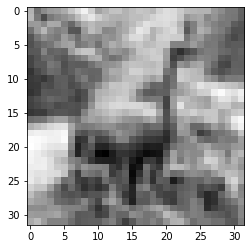

In [65]:
plt.imshow(img.mean(0), cmap='gray')
plt.show()

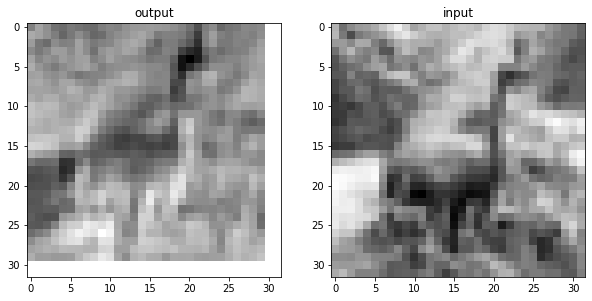

In [66]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F2_PyTorch.png')  # bookskip
plt.show()

In [67]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # <1>
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [68]:
# 希望对conv的参数进行修改，但不希望被记录
# 模糊化的kernel
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

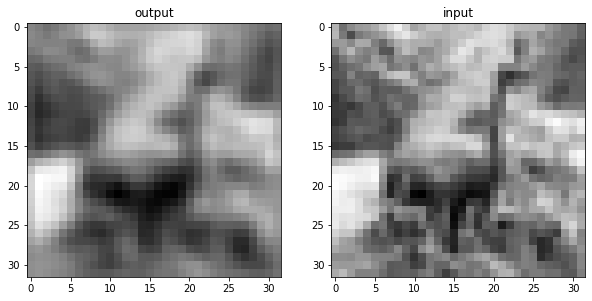

In [69]:
# matplotlib显示input & output
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F4_PyTorch.png')  # bookskip
plt.show()

In [70]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    # conv.weight.shape = (3, 1, 3, 3)
    # 而赋值tensor的shape = (3, 3) -> (1, 1, 3, 3) -> (3, 1, 3, 3)
    # 边缘加强的kernel
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

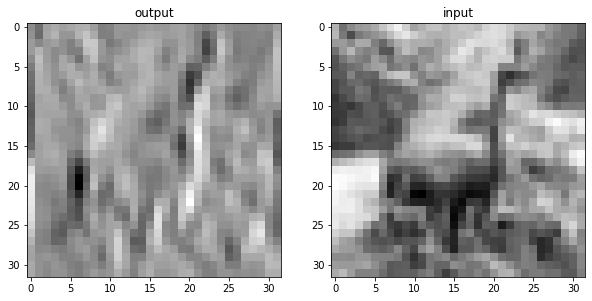

In [71]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F5_PyTorch.png')  # bookskip
plt.show()

In [72]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [73]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...
            )

In [74]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... <1>
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [75]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [76]:
model(img.unsqueeze(0))

RuntimeError: size mismatch, m1: [64 x 8], m2: [512 x 32] at /opt/conda/conda-bld/pytorch_1587428094786/work/aten/src/TH/generic/THTensorMath.cpp:41

In [77]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1>
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [78]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [79]:
import torch.nn.functional as F

# 定义baseline Module
# 把没有参数的函数放在forward里
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [80]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0157,  0.1143]], grad_fn=<AddmmBackward>)

In [81]:
import datetime  # <1>

device = torch.device('cuda:4') if torch.cuda.is_available() \
                              else torch.device('cpu')

# 训练函数
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>
            
            imgs, labels = imgs.to(device=device), labels.to(device=device)

            outputs = model(imgs)  # <4>
            
            loss = loss_fn(outputs, labels)  # <5>

            optimizer.zero_grad()  # <6>
            
            loss.backward()  # <7>
            
            optimizer.step()  # <8>

            loss_train += loss.item()  # <9>

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # <10>

In [82]:

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # <1>
print(len(train_loader)) # batch的个数(batch_size=64)
print(len(cifar2))  # cifar2数据集的数据数量
print(10000//64)    # 验证一下

model = Net().to(device=device)  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

157
10000
156
2020-08-04 16:54:22.029650 Epoch 1, Training loss 0.56348127601253
2020-08-04 16:54:30.073670 Epoch 10, Training loss 0.3277701517199255
2020-08-04 16:54:39.162895 Epoch 20, Training loss 0.30353271012093613
2020-08-04 16:54:48.182340 Epoch 30, Training loss 0.2825269956307806
2020-08-04 16:54:57.081365 Epoch 40, Training loss 0.2611521099023758
2020-08-04 16:55:05.970995 Epoch 50, Training loss 0.24111852481676516
2020-08-04 16:55:14.955705 Epoch 60, Training loss 0.22000236220800193
2020-08-04 16:55:23.784826 Epoch 70, Training loss 0.20374671763675228
2020-08-04 16:55:32.761808 Epoch 80, Training loss 0.18936982765129418
2020-08-04 16:55:41.760457 Epoch 90, Training loss 0.1728354780252572
2020-08-04 16:55:50.916288 Epoch 100, Training loss 0.1614335057604465


In [83]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

# 计算训练准确度、测试准确度
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                imgs, labels = imgs.to(device=device), labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.89


In [84]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [85]:
loaded_model = Net()  # <1>
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [86]:
device = (torch.device('cuda:4') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda:4.


In [87]:
import datetime

# 训练函数
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [88]:
# 训练baseline
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-08-04 16:55:53.068540 Epoch 1, Training loss 0.5717791305605773
2020-08-04 16:56:01.155056 Epoch 10, Training loss 0.3285352034363777
2020-08-04 16:56:10.428675 Epoch 20, Training loss 0.29493763568295034
2020-08-04 16:56:19.600949 Epoch 30, Training loss 0.2696342447381111
2020-08-04 16:56:28.821518 Epoch 40, Training loss 0.2470918864391412
2020-08-04 16:56:37.957142 Epoch 50, Training loss 0.22621280728441895
2020-08-04 16:56:47.100770 Epoch 60, Training loss 0.20994125083563434
2020-08-04 16:56:56.182746 Epoch 70, Training loss 0.1934857279252095
2020-08-04 16:57:05.294371 Epoch 80, Training loss 0.17989604251020275
2020-08-04 16:57:14.325560 Epoch 90, Training loss 0.16621195918815151
2020-08-04 16:57:23.331994 Epoch 100, Training loss 0.15666650491914932


In [89]:
# 验证baseline
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.89


In [90]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

<All keys matched successfully>

In [91]:
# 定义NetWidth Module
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [92]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

# 训练NetWidth Module
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

# 验证NetWidth Module
validate(model, train_loader, val_loader)

2020-08-04 16:57:25.070392 Epoch 1, Training loss 0.5696582414542034
2020-08-04 16:57:33.326812 Epoch 10, Training loss 0.3221928174518476
2020-08-04 16:57:42.502235 Epoch 20, Training loss 0.280595897204557
2020-08-04 16:57:51.747405 Epoch 30, Training loss 0.24590486477894388
2020-08-04 16:58:01.144278 Epoch 40, Training loss 0.21833071501771356
2020-08-04 16:58:10.267400 Epoch 50, Training loss 0.19432911556807292
2020-08-04 16:58:19.413825 Epoch 60, Training loss 0.17150816093584534
2020-08-04 16:58:28.560012 Epoch 70, Training loss 0.14893908471248712
2020-08-04 16:58:37.563124 Epoch 80, Training loss 0.12710739192879125
2020-08-04 16:58:46.685832 Epoch 90, Training loss 0.10672975324426487
2020-08-04 16:58:55.734120 Epoch 100, Training loss 0.08839293533734455
Accuracy train: 0.96
Accuracy val: 0.89


{'train': 0.9627, 'val': 0.89}

In [93]:
# 定义通用NetWidth Module
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


In [94]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

# 训练NetWidth Module
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

# 验证NetWidth Module
all_acc_dict["width"] = validate(model, train_loader, val_loader)

2020-08-04 16:58:57.388443 Epoch 1, Training loss 0.5444504941345021
2020-08-04 16:59:06.401072 Epoch 10, Training loss 0.3170766001863844
2020-08-04 16:59:16.489661 Epoch 20, Training loss 0.2745369294076968
2020-08-04 16:59:26.626298 Epoch 30, Training loss 0.24255611481750086
2020-08-04 16:59:36.650153 Epoch 40, Training loss 0.21333667237287873
2020-08-04 16:59:46.792753 Epoch 50, Training loss 0.1869501082855425
2020-08-04 16:59:56.772130 Epoch 60, Training loss 0.16314604289972098
2020-08-04 17:00:06.721299 Epoch 70, Training loss 0.14085717283331664
2020-08-04 17:00:16.695432 Epoch 80, Training loss 0.1199389615683419
2020-08-04 17:00:26.647929 Epoch 90, Training loss 0.10070081672091392
2020-08-04 17:00:36.632691 Epoch 100, Training loss 0.08321702113719123
Accuracy train: 0.96
Accuracy val: 0.90


In [95]:
sum(p.numel() for p in model.parameters())

38386

In [96]:
# 定义loss+l2reg的训练函数, 实际效果等效于在SGD设置weight_decay
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))


In [97]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001)
loss_fn = nn.CrossEntropyLoss()

# 训练loss+l2reg Module
training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

# 验证loss+l2reg Module
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2020-08-04 17:00:39.011543 Epoch 1, Training loss 0.5843232737225332
2020-08-04 17:00:50.945527 Epoch 10, Training loss 0.36670665376505274
2020-08-04 17:01:03.961225 Epoch 20, Training loss 0.3227845189298034
2020-08-04 17:01:17.150848 Epoch 30, Training loss 0.2967652347247312
2020-08-04 17:01:30.364581 Epoch 40, Training loss 0.2781612938566572
2020-08-04 17:01:43.463884 Epoch 50, Training loss 0.26434903264425363
2020-08-04 17:01:56.825599 Epoch 60, Training loss 0.25264739397035285
2020-08-04 17:02:10.330369 Epoch 70, Training loss 0.2418385104863507
2020-08-04 17:02:23.676730 Epoch 80, Training loss 0.23182862555714928
2020-08-04 17:02:36.884541 Epoch 90, Training loss 0.22235017853557684
2020-08-04 17:02:50.317798 Epoch 100, Training loss 0.21325282116604458
Accuracy train: 0.90
Accuracy val: 0.87


In [98]:
# 定义NetDropout Module
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [99]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

# 训练NetDropout Module
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

# 验证NetDropout Module
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2020-08-04 17:02:52.097544 Epoch 1, Training loss 0.5800061487847832
2020-08-04 17:03:01.319029 Epoch 10, Training loss 0.3807478230090658
2020-08-04 17:03:11.611047 Epoch 20, Training loss 0.34909007408816345
2020-08-04 17:03:21.879350 Epoch 30, Training loss 0.3298034879622186
2020-08-04 17:03:32.170678 Epoch 40, Training loss 0.3125601761090528
2020-08-04 17:03:42.365090 Epoch 50, Training loss 0.29207675567098484
2020-08-04 17:03:52.899487 Epoch 60, Training loss 0.2820587133526043
2020-08-04 17:04:03.358889 Epoch 70, Training loss 0.2723422220368294
2020-08-04 17:04:13.808153 Epoch 80, Training loss 0.2627921403403495
2020-08-04 17:04:24.129929 Epoch 90, Training loss 0.25367667208051986
2020-08-04 17:04:34.438273 Epoch 100, Training loss 0.24002674070133526
Accuracy train: 0.90
Accuracy val: 0.88


In [100]:
# 定义NetBatchNorm Module
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [101]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

# 训练NetBatchNorm Module
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

# 验证NetBatchNorm Module
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2020-08-04 17:04:36.367079 Epoch 1, Training loss 0.47399262410060616
2020-08-04 17:04:46.274422 Epoch 10, Training loss 0.25974521254468114
2020-08-04 17:04:57.181029 Epoch 20, Training loss 0.19421489422868013
2020-08-04 17:05:08.101661 Epoch 30, Training loss 0.1442583906138019
2020-08-04 17:05:18.873109 Epoch 40, Training loss 0.10167027008571443
2020-08-04 17:05:29.659437 Epoch 50, Training loss 0.0659497678754436
2020-08-04 17:05:40.533756 Epoch 60, Training loss 0.04175429383091107
2020-08-04 17:05:51.399483 Epoch 70, Training loss 0.031069264041295477
2020-08-04 17:06:02.291174 Epoch 80, Training loss 0.01645261791362694
2020-08-04 17:06:13.286825 Epoch 90, Training loss 0.010100124878393617
2020-08-04 17:06:24.257544 Epoch 100, Training loss 0.006438235058241589
Accuracy train: 1.00
Accuracy val: 0.88


In [102]:
# 定义NetDepth Module
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [103]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

# 训练NetDepth Module
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

# 验证NetDepth Module
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

2020-08-04 17:06:26.319263 Epoch 1, Training loss 0.6548019556482886
2020-08-04 17:06:37.725935 Epoch 10, Training loss 0.33992680945214193
2020-08-04 17:06:50.223275 Epoch 20, Training loss 0.30138063516206803
2020-08-04 17:07:02.679950 Epoch 30, Training loss 0.27270692026918864
2020-08-04 17:07:15.277323 Epoch 40, Training loss 0.24418729771474365
2020-08-04 17:07:27.540427 Epoch 50, Training loss 0.21705627702413852
2020-08-04 17:07:40.006214 Epoch 60, Training loss 0.1910265551251211
2020-08-04 17:07:52.616129 Epoch 70, Training loss 0.16711728478882723
2020-08-04 17:08:04.895732 Epoch 80, Training loss 0.1442026859683216
2020-08-04 17:08:17.133443 Epoch 90, Training loss 0.12163586663022923
2020-08-04 17:08:29.538488 Epoch 100, Training loss 0.09864108370035697
Accuracy train: 0.96
Accuracy val: 0.90


In [104]:
# 定义NetRes Module, 只有一个selfmap
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [105]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

# 训练NetRes Module
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

# 验证NetRes Module
all_acc_dict["res"] = validate(model, train_loader, val_loader)

2020-08-04 17:08:31.588139 Epoch 1, Training loss 0.6650077472826478
2020-08-04 17:08:42.687067 Epoch 10, Training loss 0.32934764767907987
2020-08-04 17:08:54.774148 Epoch 20, Training loss 0.28633579089763056
2020-08-04 17:09:06.986791 Epoch 30, Training loss 0.25540385922049264
2020-08-04 17:09:19.224297 Epoch 40, Training loss 0.2282854876225921
2020-08-04 17:09:31.317323 Epoch 50, Training loss 0.2022505075593663
2020-08-04 17:09:43.112028 Epoch 60, Training loss 0.17629043741305922
2020-08-04 17:09:55.091188 Epoch 70, Training loss 0.15070507236441988
2020-08-04 17:10:07.182347 Epoch 80, Training loss 0.1258206173872492
2020-08-04 17:10:19.274284 Epoch 90, Training loss 0.10219511750397409
2020-08-04 17:10:31.176941 Epoch 100, Training loss 0.07788258713853967
Accuracy train: 0.96
Accuracy val: 0.89


In [106]:
# 定义残差块
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        # kaiming_normal_: known as He initialization.
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [107]:
# 定义NetResDeep Module, 可自定义残差块数量
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    


In [108]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

# 训练NetResDeep Module
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

# 验证NetResDeep Module
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

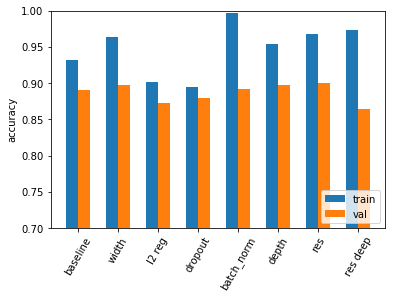

In [58]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()
